# Capstone: Sprint 2: Extended EDA
Yael Brown \
November 14, 2024 

In [158]:
# Load libraries
import numpy as np
import pandas as pd
import warnings
import time
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from datetime import datetime

In [3]:
# Suppress warnings in the notebook
warnings.filterwarnings("ignore")

## Data Preparation

In this part we are going to collect our processed data sources and then verify them before actually doing the EDA. 

In [5]:
# Load Libraries 
heist_df = pd.read_csv('../data/btc_HeistData.csv')

In [6]:
heist_df.shape

(2916697, 10)

In [7]:
# Reduce size for development
size = 50000

heist_df = heist_df.iloc[:size]

In [8]:
heist_df.columns

Index(['address', 'year', 'day', 'length', 'weight', 'count', 'looped',
       'neighbors', 'income', 'label'],
      dtype='object')

In [9]:
heist_df.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000.0,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,200000000.0,princetonCerber
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,71200000.0,princetonCerber
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,princetonLocky


In [10]:
# drop label, neighbors, looped, count, weight, length
heist_df.drop(columns=['label', 'neighbors', 'looped', 'count', 'weight', 'length'], axis=1, inplace=True)

heist_df.head()

,address,year,day,income
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,100050000.0
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,100000000.0
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,200000000.0
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,71200000.0
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,200000000.0


In [ ]:
# Convert day to month and day
df = heist_df # This made it easier to develop this process and I can switch from temp dataframe to heist_df and not worry about messing up the code

# Rename column
df.rename(columns={'day': 'day_of_year'}, inplace=True)

# Verify rename
print(df.info())

# Instantiate day and month columns that we need
df['day'] = 0
df['month'] = 0

# Add month and day (calculate it from day_of_year
# (I couldn't get df.apply() to work and reassign both columns at once) 
length = len(df)

cnt = 0
for r in range(0, length):
    print(cnt)
    row = df.iloc[r]
    date = pd.to_datetime(row['day_of_year'], format='%j', errors='coerce') + pd.DateOffset(years=row['year'] - 1970)
    row['month'] = date.month
    row['day'] = date.day
    df.iloc[r] = row
    cnt += 1

# Drop day_of_year column
df.drop(columns=['day_of_year'], axis=1, inplace=True)

# Assign back to heist_df
heist_df = df

# Clean up memory
del df

In [12]:
# Verify month and day are present. 
heist_df.head()

,address,year,income,day,month
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,100050000.0,11,1
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,100000000.0,12,5
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,200000000.0,3,9
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,71200000.0,18,11
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,200000000.0,26,8


### Import cleaned (and sampled dataset) btc transaction dataset
Here we have to import the cleaned dataset to match the sender or reciever addresses with the known heist addresses in our dataset and mark them as possible fraudulent transactions. The problem with this is that we are using a extremely small proportion of the transaction dataset and that may not be enough to have flag as possible fraud and train our model. 

The model will be trained on (target variables) address and the amount that is transferred. 

In [14]:
btc_processed_df = pd.read_csv("../data/btc_trans_data/data_raw/btc_data_cleaned.csv")

btc_processed_df.head()

,timestamp,source_address,destination_address,satoshi,year,month,day
0,1456791197,16ZZav1Cq5STgj7X5bvP9UgVYJkRk2RDdC,1KgqD2G2NSZYgHk5m7AW3wxupDj3H76Q8e,156555.0,2016,3,1
1,1456791197,16ZZav1Cq5STgj7X5bvP9UgVYJkRk2RDdC,1NZF5BEn5iCe655fj4vd5UMaXXfVvFH5aJ,26400000.0,2016,3,1
2,1456791197,1NcktapNVSfbH9FZ9mWZcgMaaokNj9Goyo,1NXmUs99Rn8FzyYMK5bmBAPL81VzmPhH9d,245057610.0,2016,3,1
3,1456791197,1NcktapNVSfbH9FZ9mWZcgMaaokNj9Goyo,1NcktapNVSfbH9FZ9mWZcgMaaokNj9Goyo,48151.0,2016,3,1
4,1456791197,1PaQM5ngUGzZYS3e9epbY7BiZvrukDoJQB,14jvp9Sj4peh28CKxifLob2jsZAcYPfZ74,20860000.0,2016,3,1


In [15]:
# Convert year, month, day to intenters
columns = ["year", "month", "day"]

btc_processed_df[columns] = btc_processed_df[columns].astype(int)

btc_processed_df.head()

,timestamp,source_address,destination_address,satoshi,year,month,day
0,1456791197,16ZZav1Cq5STgj7X5bvP9UgVYJkRk2RDdC,1KgqD2G2NSZYgHk5m7AW3wxupDj3H76Q8e,156555.0,2016,3,1
1,1456791197,16ZZav1Cq5STgj7X5bvP9UgVYJkRk2RDdC,1NZF5BEn5iCe655fj4vd5UMaXXfVvFH5aJ,26400000.0,2016,3,1
2,1456791197,1NcktapNVSfbH9FZ9mWZcgMaaokNj9Goyo,1NXmUs99Rn8FzyYMK5bmBAPL81VzmPhH9d,245057610.0,2016,3,1
3,1456791197,1NcktapNVSfbH9FZ9mWZcgMaaokNj9Goyo,1NcktapNVSfbH9FZ9mWZcgMaaokNj9Goyo,48151.0,2016,3,1
4,1456791197,1PaQM5ngUGzZYS3e9epbY7BiZvrukDoJQB,14jvp9Sj4peh28CKxifLob2jsZAcYPfZ74,20860000.0,2016,3,1


In [16]:
btc_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80120 entries, 0 to 80119
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            80120 non-null  int64  
 1   source_address       80120 non-null  object 
 2   destination_address  80120 non-null  object 
 3   satoshi              80120 non-null  float64
 4   year                 80120 non-null  int32  
 5   month                80120 non-null  int32  
 6   day                  80120 non-null  int32  
dtypes: float64(1), int32(3), int64(1), object(2)
memory usage: 3.4+ MB


In [17]:
# Create possible fraud col
btc_processed_df["isPossibleFraud"] = 0

btc_processed_df["isPossibleFraud"].head()

0    0
1    0
2    0
3    0
4    0
Name: isPossibleFraud, dtype: int64

In [18]:
btc_processed_df['year'].value_counts()

year
2016    80120
Name: count, dtype: int64

In [19]:
# Check for fraudulent rows
btc_processed_df['combined'] = btc_processed_df['source_address'] + '_' + btc_processed_df['destination_address']

matched = btc_processed_df['combined'].isin(heist_df['address'])

matched.value_counts()

combined
False    80120
Name: count, dtype: int64

In [20]:
btc_processed_df['combined']

0        16ZZav1Cq5STgj7X5bvP9UgVYJkRk2RDdC_1KgqD2G2NSZ...
1        16ZZav1Cq5STgj7X5bvP9UgVYJkRk2RDdC_1NZF5BEn5iC...
2        1NcktapNVSfbH9FZ9mWZcgMaaokNj9Goyo_1NXmUs99Rn8...
3        1NcktapNVSfbH9FZ9mWZcgMaaokNj9Goyo_1NcktapNVSf...
4        1PaQM5ngUGzZYS3e9epbY7BiZvrukDoJQB_14jvp9Sj4pe...
                               ...                        
80115    1MK7rfErwuWf12vuLxWBkn8ed9PXaeTF7W_18cfossjDMS...
80116    1N53mh1gBy9RUkqXRU85G3kU6UXmCDTSju_145NwE6sVnM...
80117    1FMYrwgYhCA71C555WWiQyi18tMPQfXGab_18cfossjDMS...
80118    13aPPSgHfd7XeJSm4b3zUm3i8CT9MEqWQp_18cfossjDMS...
80119    1Kf63JkwP8yYuSQir4HxQtrXbjJTLu16Za_18cfossjDMS...
Name: combined, Length: 80120, dtype: object

After initial examination, There was only 1 row of possible fraudulent data. To get around then it would be necessary to try to check the heist_dataframe to see if it's range is within the 2016-2018 range that we are targeting for training. 

In [22]:
# See what years are in dataset
print(heist_df['year'].value_counts(), "\n")
print(heist_df.shape)

year
2016    15631
2014    10319
2011     8652
2013     7494
2015     3701
2017     3486
2012      714
2018        3
Name: count, dtype: int64 

(50000, 5)


We only want year 2016, so we will have to extract only year 2016 and use that as our heist dataframe. 

In [24]:
# Only extract the year 2016
heist_df = heist_df[heist_df['year'] == 2016]

heist_df.shape

(15631, 5)

We want to check which months since our sample transaction data even though has ~90k records, is only for one month and not the entire year. It would be best to get the month that has the most fraudulent data to provide our model with the most possible data. 

<Axes: xlabel='month'>

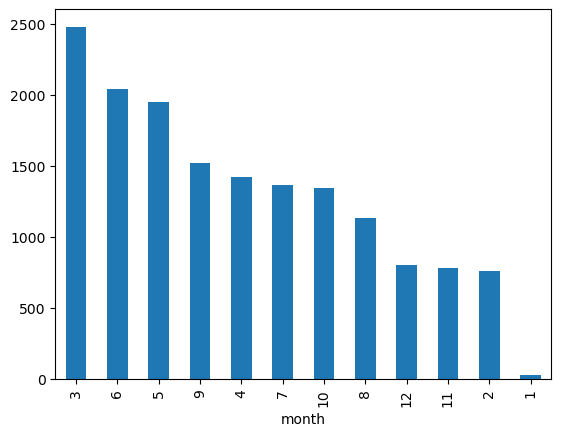

In [26]:
# Check heist df. 
heist_df['month'].value_counts().plot(kind='bar')

In [27]:
btc_processed_df['month'].value_counts()

month
3    80120
Name: count, dtype: int64

More values in heist df are in March. I will have to find a file that has more March values, and that will increase the chance of matching values and creating more values in the target variable for training. 

Currently the current file only has 12k rows in January of 2016. In our heist dataset we only have 29 possible fraudulent values in the heist dataset. 

(cheated) Asked ChatGPT for epochs for March 1, 2016 and March 31, 2016.

```
March 1, 2016 epoch: 1456790400
March 31, 2016 epoch: 1459382400
```

File '5626486' has dates in march. Re-creating cleaned_dataset.

For this codeblock we made changes to the transaction data, so we are loading it again to check for matches. We added more values and only values within the month of March. That will give us more of a chance that there is fraudulent transactions in this sample dataset. 

In [32]:
# Load data again. 
btc_processed_df = pd.read_csv("../data/btc_trans_data/data_raw/btc_data_cleaned.csv")

btc_processed_df.head()

,timestamp,source_address,destination_address,satoshi,year,month,day
0,1456791197,16ZZav1Cq5STgj7X5bvP9UgVYJkRk2RDdC,1KgqD2G2NSZYgHk5m7AW3wxupDj3H76Q8e,156555.0,2016,3,1
1,1456791197,16ZZav1Cq5STgj7X5bvP9UgVYJkRk2RDdC,1NZF5BEn5iCe655fj4vd5UMaXXfVvFH5aJ,26400000.0,2016,3,1
2,1456791197,1NcktapNVSfbH9FZ9mWZcgMaaokNj9Goyo,1NXmUs99Rn8FzyYMK5bmBAPL81VzmPhH9d,245057610.0,2016,3,1
3,1456791197,1NcktapNVSfbH9FZ9mWZcgMaaokNj9Goyo,1NcktapNVSfbH9FZ9mWZcgMaaokNj9Goyo,48151.0,2016,3,1
4,1456791197,1PaQM5ngUGzZYS3e9epbY7BiZvrukDoJQB,14jvp9Sj4peh28CKxifLob2jsZAcYPfZ74,20860000.0,2016,3,1


In [33]:
# Check which day in the month is in the sampled data. 
btc_processed_df['day'].value_counts()

day
1     78013
10      356
3       312
8       265
12      250
9       240
4       187
5       143
2       123
11      106
6        67
7        49
13        9
Name: count, dtype: int64

In [34]:
# Check which day in the month is the heist data. 
heist_df['day'].value_counts()

day
19    675
17    631
24    621
22    607
9     603
18    585
1     577
25    559
26    550
8     543
10    543
23    539
30    531
7     525
21    507
5     501
11    498
16    490
2     489
6     464
4     461
20    459
29    452
28    447
27    427
3     415
13    415
14    411
15    404
12    394
31    308
Name: count, dtype: int64

In [35]:
577 / 12052

0.047875871224692994

In [36]:
12052 * .04

482.08

We can conclude that since only the first day of the month (March 1, 2016) is in the sampled dataset that day only had 577 fraudulent transactions. That would mean the chances of fraudulent transactions is (577/96418) .005 % of the transactions. That is not very good. We may have to cheat and force some transactions in the sample dataset. 

In [38]:
# Check if there are matches
btc_processed_df['combined'] = btc_processed_df['source_address'] + '_' + btc_processed_df['destination_address']

matched = btc_processed_df['combined'].isin([heist_df['address']])

matched.value_counts()

combined
False    80120
Name: count, dtype: int64

In [39]:
# Check dataframe again
heist_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15631 entries, 1 to 41412
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   address  15631 non-null  object 
 1   year     15631 non-null  int64  
 2   income   15631 non-null  float64
 3   day      15631 non-null  int64  
 4   month    15631 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 732.7+ KB


In [40]:
# Check dataframe again
btc_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80120 entries, 0 to 80119
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            80120 non-null  int64  
 1   source_address       80120 non-null  object 
 2   destination_address  80120 non-null  object 
 3   satoshi              80120 non-null  float64
 4   year                 80120 non-null  int64  
 5   month                80120 non-null  int64  
 6   day                  80120 non-null  int64  
 7   combined             80120 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 4.9+ MB


I found it easier to manipulate sets to get unique values and check the intersection of different sets. In this case we are checking how many fraud. addresses are in the source address and destination addresses of the sampled dataset. 

In [42]:
# Use intersection and union to manipulate sets
heist_addresses = set(heist_df['address'])

source_addresses = set(btc_processed_df['source_address'])
destination_addresses = set(btc_processed_df['destination_address'])

matches_in_source = heist_addresses.intersection(source_addresses)
matches_in_destination = heist_addresses.intersection(destination_addresses)

all_matches = matches_in_source.union(matches_in_destination)

print("source_address:", len(matches_in_source))
print("destination_address:", len(matches_in_destination))

print("matching addresses:", len(all_matches))

source_address: 632
destination_address: 506
matching addresses: 681


Initially only 1 address was found. After further troubleshooting I was able to figure this out. 

In [44]:
# Only one was found. May have to cheat. 
aa = btc_processed_df[btc_processed_df['destination_address'] == '18nYi7tFNRYhyLgWwYgKSrH8KTHFcTm1yx']

print(len(aa))

1


In [45]:
heist_set_series = pd.Series(list(heist_addresses))

len(heist_set_series)

14089

I will have to use the heistdata in the combiner. Exporting the variable as a csv and using it there to get the fraudulent addresses and merge them.

In [47]:
# Saving to use in other file
heist_set_series.to_csv("heist_set_addresses.csv", index=False, header=True, sep=',')

In [48]:
# Cheated and force merged ~630 possible fraud rows from the ~2mil rows in the sampled dataset. To continue this part of EDA
btc_processed_df = pd.read_csv("../data/btc_trans_data/data_raw/btc_data_cleaned.csv")

btc_processed_df.head()

,timestamp,source_address,destination_address,satoshi,year,month,day
0,1456791197,16ZZav1Cq5STgj7X5bvP9UgVYJkRk2RDdC,1KgqD2G2NSZYgHk5m7AW3wxupDj3H76Q8e,156555.0,2016,3,1
1,1456791197,16ZZav1Cq5STgj7X5bvP9UgVYJkRk2RDdC,1NZF5BEn5iCe655fj4vd5UMaXXfVvFH5aJ,26400000.0,2016,3,1
2,1456791197,1NcktapNVSfbH9FZ9mWZcgMaaokNj9Goyo,1NXmUs99Rn8FzyYMK5bmBAPL81VzmPhH9d,245057610.0,2016,3,1
3,1456791197,1NcktapNVSfbH9FZ9mWZcgMaaokNj9Goyo,1NcktapNVSfbH9FZ9mWZcgMaaokNj9Goyo,48151.0,2016,3,1
4,1456791197,1PaQM5ngUGzZYS3e9epbY7BiZvrukDoJQB,14jvp9Sj4peh28CKxifLob2jsZAcYPfZ74,20860000.0,2016,3,1


In [49]:
# Updated dataframe
btc_processed_df.shape # Should be (80120, 7). Duplicates were also dropped. 

(80120, 7)

In [50]:
# Check cols and datatypes in dataframe
btc_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80120 entries, 0 to 80119
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            80120 non-null  int64  
 1   source_address       80120 non-null  object 
 2   destination_address  80120 non-null  object 
 3   satoshi              80120 non-null  float64
 4   year                 80120 non-null  int64  
 5   month                80120 non-null  int64  
 6   day                  80120 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 4.3+ MB


In [51]:
# Create target variable is_possible_fraud in the dataframe
btc_processed_df['is_possible_fraud'] = False

# check col
btc_processed_df['is_possible_fraud'].head()

0    False
1    False
2    False
3    False
4    False
Name: is_possible_fraud, dtype: bool

In [52]:
# Set possible fraud to true
btc_processed_df['is_possible_fraud'] = btc_processed_df['source_address'].isin(heist_set_series) | btc_processed_df['destination_address'].isin(heist_set_series)

# Convert boolean to int
btc_processed_df['is_possible_fraud'] = btc_processed_df['is_possible_fraud'].astype(int)

# check value counts
btc_processed_df['is_possible_fraud'].value_counts()

is_possible_fraud
0    77665
1     2455
Name: count, dtype: int64

## Exploratory Data Analysis
Now that we have a decent number of flagged fraudulent transactions, it's time to analyze the data and see if there are any patterns to it. 

In [54]:
# Rename dataframe to make it easy to work with
df = btc_processed_df

# Cleanup
del btc_processed_df

In [55]:
# Verify
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80120 entries, 0 to 80119
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            80120 non-null  int64  
 1   source_address       80120 non-null  object 
 2   destination_address  80120 non-null  object 
 3   satoshi              80120 non-null  float64
 4   year                 80120 non-null  int64  
 5   month                80120 non-null  int64  
 6   day                  80120 non-null  int64  
 7   is_possible_fraud    80120 non-null  int32  
dtypes: float64(1), int32(1), int64(4), object(2)
memory usage: 4.6+ MB


### Concentration of transactions
It appears there are a concentration of transactions on the first day.

<Axes: title={'center': 'Days in Transaction dataset'}, xlabel='Day', ylabel='Count'>

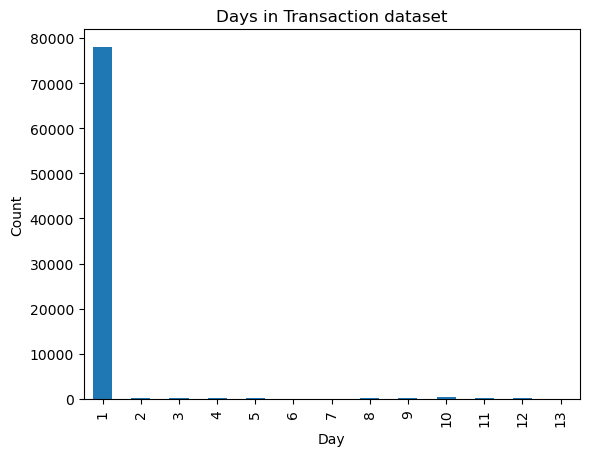

In [57]:
df['day'].value_counts().sort_index().plot(kind='bar', title='Days in Transaction dataset', ylabel='Count', xlabel='Day')

In this case, the dataset ends on the 13th day. 

<Axes: title={'center': 'Days in Transaction dataset'}, xlabel='Day', ylabel='Count'>

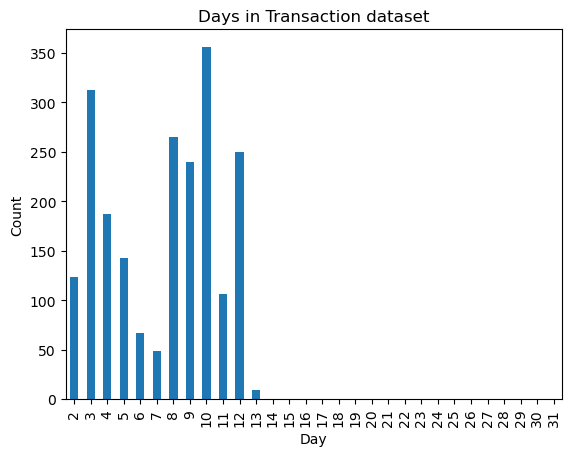

In [59]:
# Exclude the first day and look at value counts. 
temp_df = df[df['day'] != 1]

day_range = range(2, 32)
day_counts = temp_df['day'].value_counts().reindex(day_range, fill_value=0)

day_counts.sort_index().plot(kind='bar', title='Days in Transaction dataset', ylabel='Count', xlabel='Day')

We should analyze the first row. Maybe that is where the concentration of the forced fraud transactions. 

is_possible_fraud
0    77665
1      348
Name: count, dtype: int64


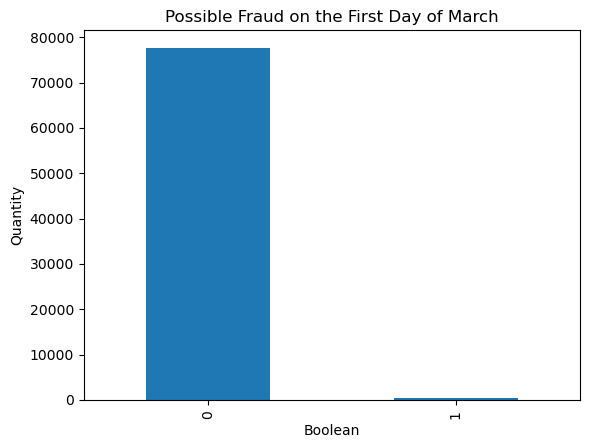

In [61]:
temp_df = df[df['day'] == 1]

temp_df['is_possible_fraud'].value_counts().plot(kind='bar', title='Possible Fraud on the First Day of March', ylabel="Quantity", xlabel="Boolean")

print(temp_df['is_possible_fraud'].value_counts())

After doing some research on March 1, 2016 it was Super Tuesday in the united states. Usually things that happen in politics often affect what happens in the crypto market. 

```
Super Tuesday in the 2016 presidential election was held on March 1, 2016. This date was dubbed the SEC Primary, since many of the participating states were represented in the U.S. Southeastern Conference for college athletics (five southern states).[27][28]

The participating states included Alabama, Arkansas, Colorado, Georgia, Massachusetts, Minnesota (with caucuses), Oklahoma, Tennessee, Texas, Vermont, and Virginia. Additionally, Republican caucuses were held in Alaska, North Dakota, and Wyoming.[28][29] The territory of American Samoa held a Democratic caucus.[29]

The Republican candidates could win about half of the 1,237 delegates needed to secure their party's presidential nomination. The two remaining Democrats were after 880 delegates, roughly one-third of those needed to win. The number of delegates from Texas is much greater than the other states: 155 for Republicans and 252 for Democrats.

The Democratic primaries and caucuses concluded with Hillary Clinton winning Alabama, Arkansas, Georgia, Massachusetts, Tennessee, Texas, and Virginia, and Bernie Sanders winning Colorado, Minnesota, Oklahoma, and Vermont. Clinton received 486 delegates, and Sanders received 321.[30] - Wikipedia
```

https://www.washingtonpost.com/politics/as-sec-primary-takes-shape-will-presidential-contenders-show-up/2015/05/23/47f9c318-0137-11e5-805c-c3f407e5a9e9_story.html

So there may have been a lot of transactions based on the sentiment after the elections. However, there were a few transactions made to or from known fraudulent addresses.

### Analyze Satoshi's (Volume)
Satoshi's is the smallest form of currency to the millionth of bitcoin. This is analogous to `$`1.00 is one dollar and `$`.01 is one cent. Up to 99 cents you can have before having a dollar. You can have .9999999 Satoshi's before you have 1 Bitcoin (BTC). 

Volume is the measurement of transactions. This would include buying Bitcoin, Selling Bitcoin to fiat (dollars, pesos, etc.) and wallet to wallet transfers. 

In [64]:
# Method to convert values of satoshi's to bitcoin
def sat_to_btc(sats):
    return sats / 100000000

day
1    1050048
2        892
3       6292
4       2202
5       2726
6       1194
7         93
8       4785
9       3168
10      6387
11      1160
12      7763
13         2
Name: satoshi, dtype: float64
Total btc's in dataset:  1086712.70612756


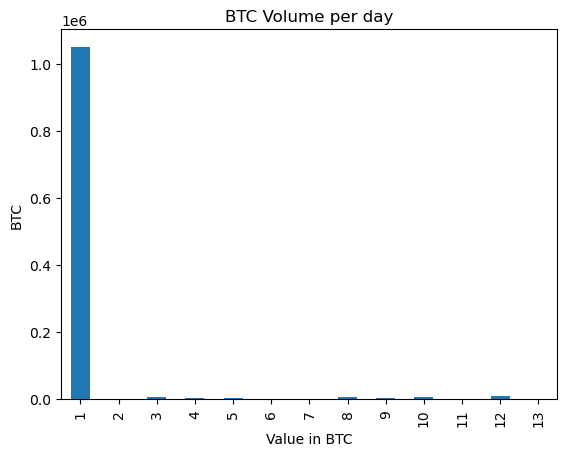

In [254]:
df_satoshis = df.groupby(['day'])['satoshi'].sum().apply(sat_to_btc)

# Set float format to reduce confusion
df_satoshis.apply(lambda x: f"{x:.0f}")

df_satoshis.plot(kind='bar', title="BTC Volume per day", ylabel="BTC", xlabel="Value in BTC")

print(df_satoshis)
print("Total btc's in dataset: ", sat_to_btc(df['satoshi'].sum()))

In [238]:
df.groupby(['day'])['satoshi'].sum().apply(sat_to_btc).describe()

count    1.300000e+01
mean     8.359329e+04
std      2.903945e+05
min      2.004100e+00
25%      1.159542e+03
50%      2.726363e+03
75%      6.292486e+03
max      1.050048e+06
Name: satoshi, dtype: float64

We will have to exclude the first day to analyze the daily volume. 

<Axes: title={'center': 'BTC Volume per day (minus the first)'}, xlabel='Value in BTC', ylabel='BTC'>

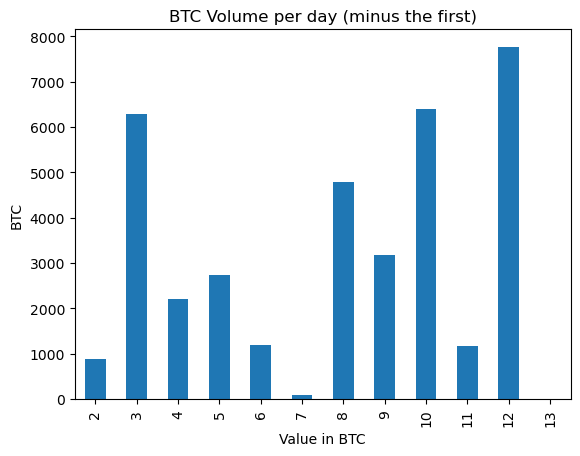

In [203]:
# temp_sats = temp_df[df[]].groupby(['day'])['satoshi']
temp_sats = df[df['day'] != 1].groupby(['day'])['satoshi'].sum().apply(sat_to_btc)

temp_sats.plot(kind='bar', title="BTC Volume per day (minus the first)", ylabel="BTC", xlabel="Value in BTC")

This shows a distributed amount of volume after the first. I can't identify a real pattern from that besides day 7 was low. 

Look at the distribution of possible fraudulent data. 

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80120 entries, 0 to 80119
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            80120 non-null  int64  
 1   source_address       80120 non-null  object 
 2   destination_address  80120 non-null  object 
 3   satoshi              80120 non-null  float64
 4   year                 80120 non-null  int64  
 5   month                80120 non-null  int64  
 6   day                  80120 non-null  int64  
 7   is_possible_fraud    80120 non-null  int32  
dtypes: float64(1), int32(1), int64(4), object(2)
memory usage: 4.6+ MB


<Axes: title={'center': 'Quantity of Poss. Fraud'}, xlabel='Day Number', ylabel='Number of Tx'>

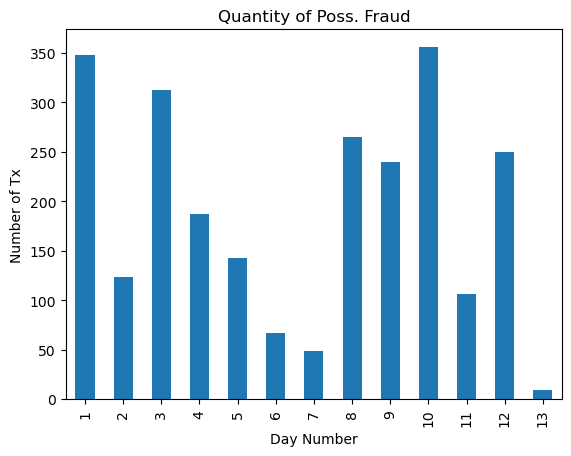

In [71]:
# Quantity of Possible Fraud
df_fraud = df[df['is_possible_fraud'] == 1].groupby(['day'])
df_fraud = df_fraud['is_possible_fraud'].count()

df_fraud.plot(kind='bar', title="Quantity of Poss. Fraud", ylabel="Number of Tx", xlabel="Day Number")

Looking at this distribution, it's more randomly distributed.

<Axes: title={'center': 'Volume of Poss. Fraud'}, xlabel='Day Number', ylabel='Number of Tx'>

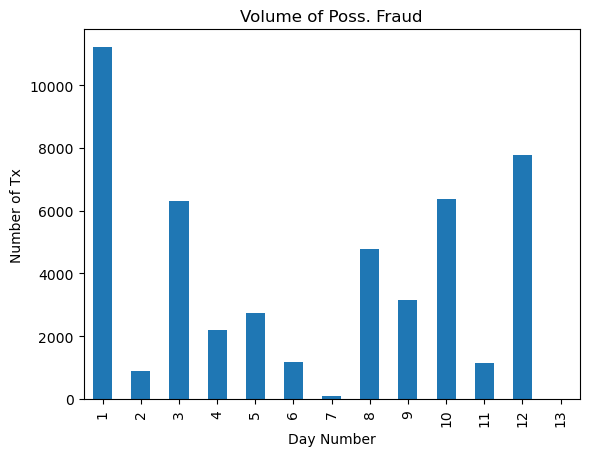

In [73]:
# Volume of Possible Fraud
df_satoshis_fraud = df[df['is_possible_fraud'] == 1].groupby(['day'])['satoshi'].sum().apply(sat_to_btc)
df_satoshis_fraud.plot(kind='bar', title="Volume of Poss. Fraud", ylabel="Number of Tx", xlabel="Day Number")

In this graph, it appears that the first day like before has a the largest volume of possible fraudulent transactions. Day 7 and 13 are the lowest of possible transactions but also in the previous volume graph it has a lower amount of transactions.

## Preliminary Modeling. 
Preliminary modeling. Since this is a classification problem trying to identify fraud we can do a Logistic Regression model. We will take our data, throw it in the model and get an initial baseline of where we are at and test the accuracy. 

In [76]:
# do train test split on the data
# Train the model
# Run tests

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80120 entries, 0 to 80119
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            80120 non-null  int64  
 1   source_address       80120 non-null  object 
 2   destination_address  80120 non-null  object 
 3   satoshi              80120 non-null  float64
 4   year                 80120 non-null  int64  
 5   month                80120 non-null  int64  
 6   day                  80120 non-null  int64  
 7   is_possible_fraud    80120 non-null  int32  
dtypes: float64(1), int32(1), int64(4), object(2)
memory usage: 4.6+ MB


#### Train Test Split
The addresses will have to be encoded in order to run through model more accurately. It converts the btc addresses to integer values. Then the data is scaled using the standard scaler. 

In [163]:
# Train Test Split (ttS)
# Extract target variable
X = df[['source_address', 'destination_address', 'satoshi', 'timestamp', 'year', 'month', 'day']]
y = df['is_possible_fraud']

# Encode categorical data (convert addresses to single digits)
enc = LabelEncoder()
X['source_address'] = enc.fit_transform(X['source_address'])
X['destination_address'] = enc.fit_transform(X['destination_address'])

# Scale numerical features
scaler = StandardScaler()
X[['satoshi', 'timestamp', 'year', 'month', 'day']] = scaler.fit_transform(X[['satoshi', 'timestamp', 'year', 'month', 'day']])

# tts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Train model
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [168]:
X_train.head()

,source_address,destination_address,satoshi,timestamp,year,month,day
75288,11812,17757,-0.184233,-0.134205,0.0,0.0,-0.145564
44607,12788,9371,-0.207944,-0.154380,0.0,0.0,-0.145564
50936,11865,11924,-0.207940,-0.154380,0.0,0.0,-0.145564
22869,20701,27159,-0.192616,-0.156511,0.0,0.0,-0.145564
39205,9783,6776,-0.207913,-0.154380,0.0,0.0,-0.145564


#### Evaluate Model
The accuracy is calculated from the initial model. Then a confusion matrix is used to give a breakdown of the model predictions. 

Accuracy:  0.9996217851739788


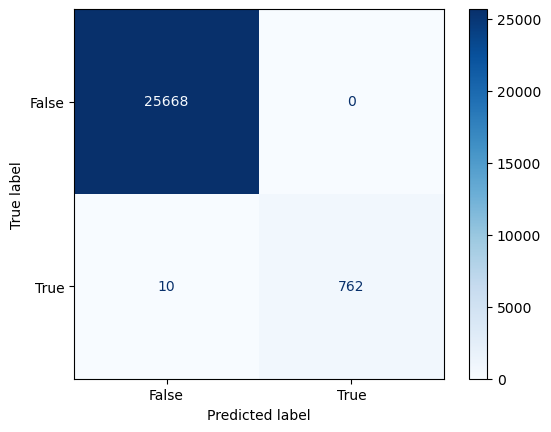

In [262]:
# Eval model
accuracy = lr.score(X_test, y_test)

print("Accuracy: ", accuracy)

y_pred = lr.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["False", "True"])

cmd.plot(cmap='Blues')

It appears the model has 99% accuracy in predicting fraudulent transactions with the test set. This would need to be further evaluated to see if its accurate. There is a 0 indicating in the (0,1) position that out of all the Trufy predictions there was not one that was really a false flag. Further investigation would need to go into the model and the dataset. 

In [1]:
1 - 0.9996217851739788

0.0003782148260211837